### Задание для курсового проекта
Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

Срок сдачи 7.06
Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
Необходимо получить R2 > 0.6.
Укажите свой ник на kaggle
Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):

Файл должен содержать заголовки и комментарии
Повторяющиеся операции лучше оформлять в виде функций
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

### Добавление библиотек и скриптов


In [130]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [26]:
from scipy.stats import norm
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Загрузка данных

In [6]:
train_df = pd.read_csv('geekbrainscloud/train.csv')

In [7]:
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


In [8]:
test_df = pd.read_csv('geekbrainscloud/test.csv')

In [9]:
test_df.tail(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4990,15706,94,2.0,47.776485,27.920873,6.0,8,9.0,1970,0.282798,B,B,33,8667,2,NaN,0,6,B
4991,2105,64,2.0,45.493240,32.022565,6.0,4,9.0,1974,0.135650,B,B,46,7960,6,350.0,3,11,B
4992,7220,96,3.0,80.182493,48.627326,10.0,10,17.0,2003,0.041116,B,B,53,14892,4,NaN,1,4,B
4993,14562,113,2.0,46.627882,27.058739,5.0,6,5.0,1969,0.307467,B,A,30,5048,9,325.0,2,5,B
4994,6836,39,2.0,45.131282,30.780551,6.0,2,5.0,1965,0.428826,B,B,25,5011,8,730.0,0,2,B
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [11]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### Приведение типов

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['Rooms'] = train_df['Rooms'].astype(int)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(int)

In [13]:
train_df.dtypes

Id                object
DistrictId        object
Rooms              int64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor         int64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### EDA

### Целевая переменная

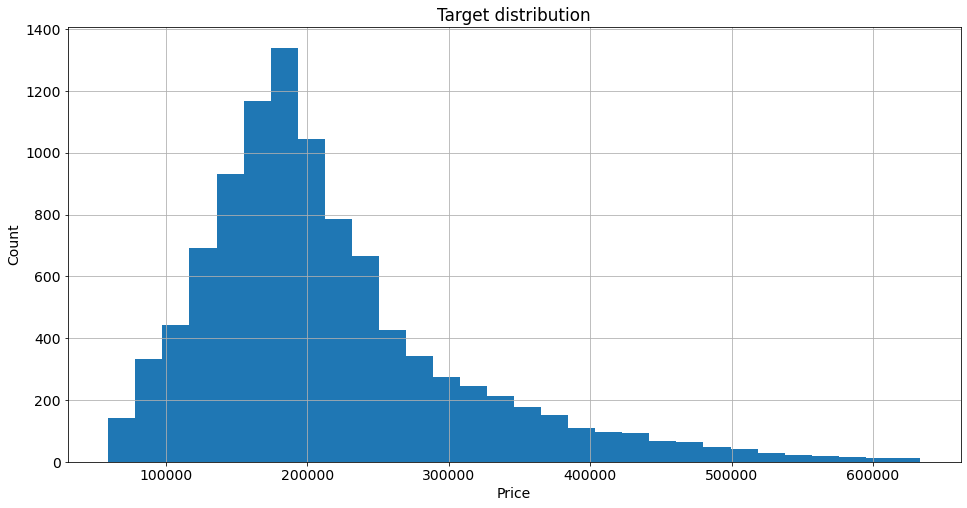

In [14]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

### Количественные переменные


In [15]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


 ### Обработка выбросов и заполнение пропусков

 1.Rooms

In [16]:
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [18]:
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = int(train_df['Rooms'].mean())
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1

In [19]:
train_df['Rooms'].value_counts()

2    3880
1    3717
3    2235
4     150
5      18
Name: Rooms, dtype: int64

2.Square

In [27]:
train_df.loc[train_df['Square'] > 150].nlargest(10, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6977,11602,30,2,641.065193,638.163193,10.0,20,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
4262,28,9,2,604.705972,NaN,1.0,17,18,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4690,2307,102,1,409.425181,410.639749,10.0,4,4,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
1982,5548,86,5,275.645284,233.949309,26.0,12,37,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
1981,7917,27,1,212.932361,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
9910,16568,27,4,200.334539,201.627361,25.0,1,2,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016
8511,4249,23,5,198.930182,123.139863,10.0,1,2,2011,0.014073,B,B,2,475,0,NaN,0,0,B,345665.209100
652,3718,56,3,190.857689,107.376164,19.0,7,3,2007,0.000000,B,B,23,5067,4,NaN,2,6,B,338644.075979
7201,3233,129,4,186.692602,87.487080,32.0,3,3,2011,0.020741,B,B,24,5613,5,1340.0,2,5,B,423443.464367
5087,15947,129,4,185.906396,84.830074,31.0,5,3,2015,0.020741,B,B,24,5613,5,1340.0,2,5,B,340273.238253


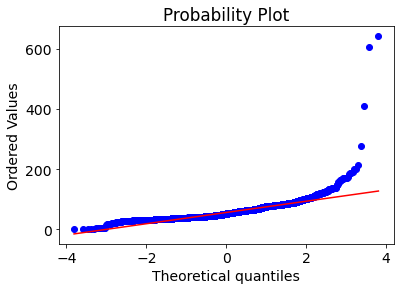

In [29]:
fig = plt.figure()
res = stats.probplot(train_df['Square'], plot=plt)
plt.show()

In [30]:
train_df.loc[train_df['Square'] > 280, 'Square'] = train_df['Square'].median()

3. LifeSquare

In [31]:
train_df.loc[train_df['Square'] < train_df['LifeSquare'], \
             'LifeSquare'] = train_df.loc[train_df['Square'] < train_df['LifeSquare'], 'Square']

In [32]:
train_df['LifeSquare'] = train_df['LifeSquare'].fillna(train_df['LifeSquare'].mean())

In [59]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare'].mean()

4. HouseYear

In [34]:
train_df.loc[train_df['HouseYear'] > 2021].nlargest(10, 'HouseYear')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1,37.265070,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2,44.791836,28.360393,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [35]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021
train_df.loc[train_df['HouseYear'] < 1900, 'HouseYear'] = train_df['HouseYear'].median()

5. Health_care_1

In [37]:
train_df['Healthcare_1'] = train_df['Healthcare_1'].fillna(train_df['Healthcare_1'].mean())

6. KitchenSquare

In [43]:
train_df.loc[(train_df['KitchenSquare'] > 40)].nlargest(30, 'KitchenSquare')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1,47.100719,46.447960,2014.0,4,1,2014,0.072158,B,B,2,629,1,1142.90446,0,0,A,108337.484207
8584,14679,81,1,32.276663,19.278394,1970.0,6,1,1977,0.006076,B,B,30,5285,0,645.00000,6,6,B,105539.556275
9895,2737,27,3,123.430072,123.430072,123.0,5,10,2015,0.017647,B,B,2,469,0,1142.90446,0,0,B,234194.837047
4651,12552,58,3,116.405693,113.109653,112.0,3,3,2016,0.437885,B,B,23,5735,3,1084.00000,0,5,B,296165.936689
2969,7441,62,3,114.734473,112.589083,112.0,3,3,2015,0.072158,B,B,2,629,1,1142.90446,0,0,A,315245.521059
2916,12390,72,3,97.490674,97.490674,96.0,22,25,2019,0.210473,B,B,11,2398,2,1994.00000,3,0,B,445074.956552
7088,6569,27,1,38.220258,18.716856,84.0,4,17,2018,0.011654,B,B,4,915,0,1142.90446,0,0,B,99079.960518
1455,12507,54,2,79.810535,79.578961,78.0,10,15,2014,0.006076,B,B,30,5285,0,645.00000,6,6,B,438708.707579
6240,4966,96,3,78.445675,47.146757,75.0,9,12,1977,0.041116,B,B,53,14892,4,1142.90446,1,4,B,290354.484070
5149,13703,42,1,38.071692,19.723548,73.0,9,10,2006,0.158249,B,B,21,5731,0,1142.90446,1,0,B,160488.033165


In [44]:
train_df.loc[train_df['KitchenSquare'] > 43, 'KitcheSquare'] = train_df['KitchenSquare'].mean()

In [45]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        

7. House Floor

In [47]:
train_df.loc[(train_df['HouseFloor'] < train_df['Floor']), 'HouseFloor'] = train_df['Floor']

In [49]:
class DataPreprocessing:
    
    def __init__(self):
        
        self.means=None
        
    def fit(self, X):
        
        self.means = X.mean()
        self.medians = X.median()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.means['Rooms']
        
        # Square
        X.loc[X['Square'] > 280, 'Square'] = self.medians['Square']
        
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > 43)
        X.loc[condition, 'KitchenSquare'] = self.means['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor
        X.loc[(X['HouseFloor'] < X['Floor']), 'HouseFloor'] = X['Floor']
        
        # HouseYear
        
        
        X.loc[X['HouseYear'] > 2021, 'HouseYear'] = 2021
        X.loc[X['HouseYear'] < 1900, 'HouseYear'] = self.medians['HouseYear']
                   
        X.fillna(self.means, inplace=True)
        
        return X

### Построение новых признаков

In [50]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [51]:
info_by_district_id = train_df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})

train_df = pd.merge(train_df, info_by_district_id, on=[
        'DistrictId', 'Rooms', 'HouseYear'], how='left')

In [53]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,KitcheSquare,mean_square_rooms_dr
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,2.200000e+01,10000.000000
mean,1.887200,56.166010,35.929244,6.974800,8.526700,13.435700,1984.872600,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,0.917500,214138.857399,6.273300e+00,56.166010
std,0.811629,19.149659,15.678836,28.443436,5.241148,6.094012,18.416734,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,736.734238,1.493601,4.806341,0.275139,92872.293865,2.727239e-15,17.951491
min,1.000000,1.136859,0.370619,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,6.273300e+00,16.547242
25%,1.000000,41.774881,25.494155,3.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942,6.273300e+00,42.721787
50%,2.000000,52.513040,35.929244,6.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1142.904460,1.000000,3.000000,1.000000,192269.644879,6.273300e+00,52.167147
75%,2.000000,65.889736,41.167913,9.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,1142.904460,2.000000,6.000000,1.000000,249135.462171,6.273300e+00,64.721376
max,5.000000,275.645284,233.949309,2014.000000,42.000000,117.000000,2021.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570,6.273300e+00,275.645284


In [80]:
train_df['mean_price_dr'] = train_df['mean_price_dr'].fillna(price)
train_df['mean_price_by_rooms'] = train_df['mean_price_by_rooms'].fillna(price)

In [84]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,mean_price_dr_y,mean_price_by_rooms_y,mean_price_dr_x,mean_price_by_rooms_x,mean_price_dr_y,mean_price_by_rooms_y,mean_price_dr_x,mean_price_by_rooms_x,mean_price_dr_y,mean_price_by_rooms_y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887200,56.166010,36.892727,6.974800,8.526700,13.435700,1984.872600,0.118858,0.990300,0.972500,...,214138.857399,214138.857399,214138.857399,214138.857399,214138.857399,214138.857399,214138.857399,214138.857399,214138.857399,214138.857399
std,0.811629,19.149659,15.409937,28.443436,5.241148,6.094012,18.416734,0.119025,0.098015,0.163543,...,74536.817443,53415.501256,74536.817443,53415.501256,74536.817443,53415.501256,74536.817443,53415.501256,74536.817443,53415.501256
min,1.000000,1.136859,-5.837941,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,...,82342.775873,159980.716967,82342.775873,159980.716967,82342.775873,159980.716967,82342.775873,159980.716967,82342.775873,159980.716967
25%,1.000000,41.774881,27.585105,3.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,...,166014.055413,159980.716967,166014.055413,159980.716967,166014.055413,159980.716967,166014.055413,159980.716967,166014.055413,159980.716967
50%,2.000000,52.513040,35.929244,6.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,...,198777.278269,215256.306416,198777.278269,215256.306416,198777.278269,215256.306416,198777.278269,215256.306416,198777.278269,215256.306416
75%,2.000000,65.889736,42.093884,9.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,...,248821.481005,215256.306416,248821.481005,215256.306416,248821.481005,215256.306416,248821.481005,215256.306416,248821.481005,215256.306416
max,5.000000,275.645284,233.949309,2014.000000,42.000000,117.000000,2021.000000,0.521867,1.000000,1.000000,...,624156.003381,410431.605679,624156.003381,410431.605679,624156.003381,410431.605679,624156.003381,410431.605679,624156.003381,410431.605679


In [93]:
price = train_df['Price'].mean()
price_mean_by_rooms = train_df.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
    rename(columns={'Price': 'mean_price_by_rooms'})

price_mean_by_distr_rooms = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
    rename(columns={'Price': 'mean_price_dr'})

train_df = pd.merge(train_df, price_mean_by_distr_rooms, on=[
        'DistrictId', 'Rooms'], how='left')
train_df = pd.merge(train_df, price_mean_by_rooms, on='Rooms', how='left')

In [94]:
train_df['mean_price_dr'] = train_df['mean_price_dr'].fillna(train_df['mean_price_by_rooms'])
train_df['mean_price_dr'] = train_df['mean_price_dr'].fillna(price)
train_df['mean_price_by_rooms'] = train_df['mean_price_by_rooms'].fillna(price)

In [95]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,KitcheSquare,mean_square_rooms_dr,mean_price_by_kitchen,mean_price_dr,mean_price_by_rooms
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,2.200000e+01,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887200,56.166010,36.892727,6.974800,8.526700,13.435700,1984.872600,0.118858,0.990300,0.972500,...,1142.904460,1.319500,4.231300,0.917500,214138.857399,6.273300e+00,56.166010,214138.857399,214138.857399,214138.857399
std,0.811629,19.149659,15.409937,28.443436,5.241148,6.094012,18.416734,0.119025,0.098015,0.163543,...,736.734238,1.493601,4.806341,0.275139,92872.293865,2.727239e-15,17.951491,86246.259541,74536.817443,53415.501256
min,1.000000,1.136859,-5.837941,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,59174.778028,6.273300e+00,16.547242,59174.778028,82342.775873,159980.716967
25%,1.000000,41.774881,27.585105,3.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,...,830.000000,0.000000,1.000000,1.000000,153872.633942,6.273300e+00,42.721787,172612.293590,166014.055413,159980.716967
50%,2.000000,52.513040,35.929244,6.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,...,1142.904460,1.000000,3.000000,1.000000,192269.644879,6.273300e+00,52.167147,181829.888290,198777.278269,215256.306416
75%,2.000000,65.889736,42.093884,9.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,...,1142.904460,2.000000,6.000000,1.000000,249135.462171,6.273300e+00,64.721376,240835.874736,248821.481005,215256.306416
max,5.000000,275.645284,233.949309,2014.000000,42.000000,117.000000,2021.000000,0.521867,1.000000,1.000000,...,4849.000000,6.000000,23.000000,1.000000,633233.466570,6.273300e+00,275.645284,625678.644994,624156.003381,410431.605679


In [120]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.mean_square_rooms_dr= None
        self.mean_price_by_rooms = None
        self.mean_price_dr = None
        self.mean_price_by_kitchen = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
                
        # Target encoding
             ## District, Rooms
        df = X.copy()
        
        if y is not None:
            
            df['Price'] = y.values
            
            self.mean_square_rooms_dr = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg({'Square': 'mean'}).\
                        rename(columns={'Square': 'mean_square_rooms_dr'})
            
            self.mean_square_rooms_dr_means = self.mean_square_rooms_dr['mean_square_rooms_dr'].mean()
            
            
            ## Mean price by rooms
            self.mean_price_by_rooms = df.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
                        rename(columns={'Price': 'mean_price_by_rooms'})
            
            self.mean_price_by_rooms_means = self.mean_price_by_rooms['mean_price_by_rooms'].mean()
            
            
            
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        
        # Target encoding
        if self.mean_price_by_kitchen is not None:
            X = X.merge(self.mean_price_by_kitchen, on=['DistrictId', 'Rooms', 'HouseYear'], how='left')
            X.fillna(self.mean_price_by_kitchen_means, inplace=True)
            
        if self.mean_price_by_rooms is not None:
            X = X.merge(self.mean_price_by_rooms, on=['Rooms'], how='left')
            X.fillna(self.mean_price_by_rooms_means, inplace=True)
        
        if self.mean_price_dr is not None:
            X = X.merge(self.mean_price_dr, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.mean_price_by_rooms_means, inplace=True)
                                                
        
        return X
    

            

In [112]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'KitcheSquare',
 'mean_square_rooms_dr',
 'mean_price_by_kitchen',
 'mean_price_dr',
 'mean_price_by_rooms']

In [113]:
train_df = pd.read_csv('geekbrainscloud/train.csv')

In [114]:
test_df = pd.read_csv('geekbrainscloud/test.csv')

In [115]:
X = train_df.drop(columns='Price')

In [116]:
y = train_df['Price']

In [117]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [118]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 19), (3300, 19), (5000, 19))

In [121]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 20), (3300, 20), (5000, 20))

In [122]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Train R2:	0.962
Test R2:	0.725


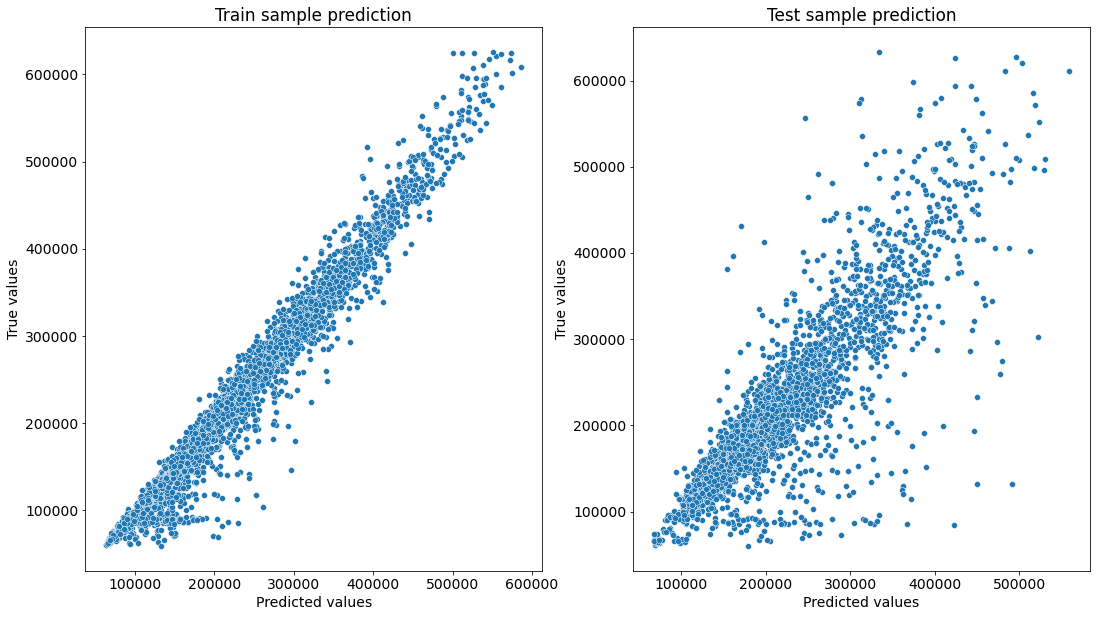

In [123]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [124]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.7108397 , 0.69730174, 0.73016667])

In [125]:
cv_score.mean()

0.7127693701283063